In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/My Drive/Research/EduKC/unstructured/activity-hero-new.csv')
df = df.drop('location.1',axis=1)# df.columns = list(range(8))
df.head()

,title,location,category,image,description,details,provider,distance,ages,price,campus
0,KidzToPros,Multiple Locations,Hip Hop Online Course Free Activities,https://images.activityhero.com/provider_photo...,From coding in scratch and python to LEGO Mast...,https://www.activityhero.com/biz/kidztopros,https://images.activityhero.com/59989/crop/bfc...,7.0,"5, 17",140,m
1,Petits Pas,Multiple Locations,Crafts Dance Yoga,https://images.activityhero.com/provider_photo...,"By combining a variety of classes (Yoga, Balle...",https://www.activityhero.com/biz/petits-pas,https://images.activityhero.com/58965/crop/399...,12.9,"5, 17",0,f
2,Crissy Field Center Summer Camp,"Crissy Field Center - San Francisco, CA",Nature Programs Backpacking Adventure/Outdoors,https://images.activityhero.com/provider_photo...,About Crissy Field CenterThe Crissy Field Cent...,https://www.activityhero.com/biz/2575-crissy-f...,https://images.activityhero.com/2179/crop/de98...,23.9,",18",100,"m,f"
3,Early Childhood Matters,Multiple Locations,Family Mindfulness Preschool,https://images.activityhero.com/provider_photo...,Supporting Families on the Road to Connected a...,https://www.activityhero.com/biz/early-childho...,https://images.activityhero.com/57089/crop/989...,24.6,"5,18",45,"m,f"
4,Art School of SF Bay,Multiple Locations,Cartooning Visual Arts Drawing and Painting,https://images.activityhero.com/provider_photo...,We teach classical art - in a modern way. Our ...,https://www.activityhero.com/biz/art-school-of...,https://images.activityhero.com/10531/crop/150...,25.0,"5, 17",110,"m,f"


In [5]:
df = df[['description']]
df

,description
0,From coding in scratch and python to LEGO Mast...
1,"By combining a variety of classes (Yoga, Balle..."
2,About Crissy Field CenterThe Crissy Field Cent...
3,Supporting Families on the Road to Connected a...
4,We teach classical art - in a modern way. Our ...
...,...
995,Golden Eagle Summer Sports Camp is a full-faci...
996,"The class will focus on skateboarding basics, ..."
997,Spartans Sports Camp offers a wide variety of ...
998,The SJ Chess Club hosted by AcademiCare offers...


In [7]:
df = pd.read_json('/content/drive/My Drive/Research/EduKC/unstructured/result.json')
df.columns

Index(['description', 'camp_type', 'topics'], dtype='object')

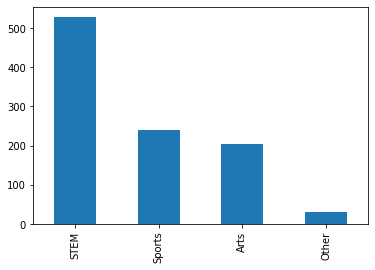

In [9]:
df[df['camp_type'] == 'Art'] = 'Other'
df['camp_type'].value_counts().plot.bar()

### Data Preprocessing and test train split

In [10]:
from tqdm import tqdm
# tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

X_train, X_test, y_train, y_test = train_test_split(df.description, df.camp_type, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

### Preprocessing: Word Embedding

In [11]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 1000/1000 [00:00<00:00, 408841.41it/s]


#### Corpus to Vectors

In [12]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

### Keras classification model

In [25]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df) * .7)
train_posts = df['description'][:train_size]
train_tags = df['camp_type'][:train_size]

test_posts = df['description'][train_size:]
test_tags = df['camp_type'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 20

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/20
20/20 [==============================] - 0s 10ms/step - loss: 1.1844 - accuracy: 0.4619 - val_loss: 1.0425 - val_accuracy: 0.4857
Epoch 2/20
20/20 [==============================] - 0s 5ms/step - loss: 0.8411 - accuracy: 0.6048 - val_loss: 0.9328 - val_accuracy: 0.5429
Epoch 3/20
20/20 [==============================] - 0s 5ms/step - loss: 0.6201 - accuracy: 0.7984 - val_loss: 0.8634 - val_accuracy: 0.6571
Epoch 4/20
20/20 [==============================] - 0s 5ms/step - loss: 0.4593 - accuracy: 0.9000 - val_loss: 0.8316 - val_accuracy: 0.6143
Epoch 5/20
20/20 [==============================] - 0s 5ms/step - loss: 0.3234 - accuracy: 0.9397 - val_loss: 0.8038 - val_accuracy: 0.6429
Epoch 6/20
20/20 [==============================] - 0s 5ms/step - loss: 0.2427 - accuracy: 0.9714 - val_loss: 0.8106 - val_accuracy: 0.6571
Epoch 7/20
20/20 [==============================] - 0s 5ms/step - loss: 0.1687 - accuracy: 0.9857 - val_loss: 0.8246 - val_accuracy: 0.6571
Epoch 8/20
20/20 [=

In [14]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

10/10 [==============================] - 0s 2ms/step - loss: 0.9278 - accuracy: 0.5933
Test accuracy: 0.5933333039283752


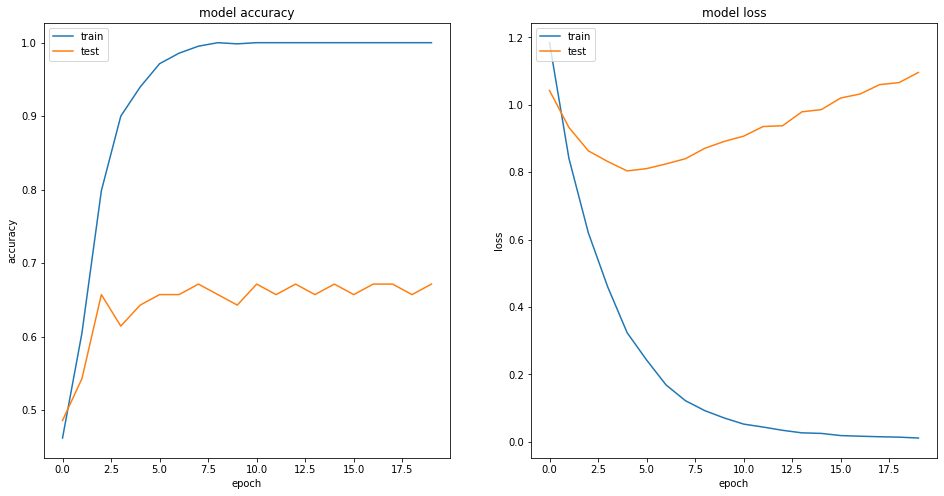

In [31]:
plt.figure(figsize=(16, 8))
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
train_posts[0]

'From coding in scratch and python to LEGO Masters, graphic design, art skills, sports and more, KidzToPros takes fun and enrichment to the next level! Our…read more >'

In [16]:
x = tokenize.texts_to_matrix(train_posts[0])

In [24]:
classes = ['Other', 'Arts', 'Sports', 'STEM' ]

In [23]:
classes[np.argmax(model.predict(x), axis=-1)[0]]

'Sports'

In [20]:
encoder.transform(['STEM', 'Sports', 'Arts', 'Other'])

array([2, 3, 0, 1])